# High-Frequency Trading Assignment
### Goal: Become familiar with high frequency data    


The rough outline of this notebook is as follows:
1. Load in tick data for two ticker (AAPL and GME) for one day (08/30/17) from OneTick 
2. Use the created class DataSummary to obtain a bunch of different summary statistics for the dataset
3. Plot the results for the securities
4. Load in and preprocess the currencies datasets (and manually create the limit order book)
5. Repeat steps 2 and 3 for the currencies


## Loading in and processing data from OneTick

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as md
from matplotlib import rcParams
import seaborn as sns

rcParams['timezone'] = 'US/Eastern'

In [2]:
# change default plotting
mpl.style.use('seaborn-whitegrid')
mpl.rcParams['axes.grid.axis'] = 'both'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.figsize'] = [7, 5]
# mpl.rcParams.keys()

In [3]:
USER = 'philip_spalding@mfe.berkeley.edu'
PASSWORD = 'vBlqHHtX2x'

In [4]:
def get_data(query, user, password):
    response = requests.get(query, auth=requests.auth.HTTPBasicAuth(user, password)).content
    df = pd.read_csv(io.StringIO(response.decode('utf-8')), low_memory=False)
    df.rename(columns={"#TIMESTAMP": "TIMESTAMP"}, inplace=True)

    # if pulling more than one symbol at a time we get more than one header so we drop that row
    df.drop(df.index[df['TIMESTAMP'] == '#TIMESTAMP'], axis=0, inplace=True)

    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='ms').dt.tz_localize('US/Eastern')
    
    return df

In [5]:
trade_query = 'https://data.onetick.com:443/omdwebapi/rest/?params={"context":"DEFAULT","query_type":"otq","otq":"124/734/otq/f509f3e7-70d8-4950-871f-c3348d828f5e.otq","enable_per_symbol_errors":"false","s":"20170830093000","e":"20170830160000","timezone":"America/New_York","response":"csv","format":["order=TIMESTAMP|PRICE|SIZE|TRADE_ID|BUY_SELL_FLAG|TRADE_ID"]}'
trade_df = get_data(trade_query, USER, PASSWORD)
trade_df.head()

,TIMESTAMP,PRICE,SIZE,TRADE_ID,BUY_SELL_FLAG,SYMBOL_NAME
0,2017-08-30 13:30:00.006000-04:00,163.720000,210,39308,1,NASDAQ::AAPL
1,2017-08-30 13:30:00.064000-04:00,163.720000,300,41757,1,NASDAQ::AAPL
2,2017-08-30 13:30:00.098000-04:00,163.720000,100,43884,1,NASDAQ::AAPL
3,2017-08-30 13:30:00.125000-04:00,163.720000,5,46241,1,NASDAQ::AAPL
4,2017-08-30 13:30:00.273000-04:00,163.800000,6992,49953,1,NASDAQ::AAPL


In [6]:
trade_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45050 entries, 0 to 45050
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype                     
---  ------         --------------  -----                     
 0   TIMESTAMP      45050 non-null  datetime64[ns, US/Eastern]
 1   PRICE          45050 non-null  object                    
 2   SIZE           45050 non-null  object                    
 3   TRADE_ID       45050 non-null  object                    
 4   BUY_SELL_FLAG  45050 non-null  object                    
 5   SYMBOL_NAME    45050 non-null  object                    
dtypes: datetime64[ns, US/Eastern](1), object(5)
memory usage: 2.4+ MB


In [7]:
order_query = 'https://data.onetick.com:443/omdwebapi/rest/?params={"context":"DEFAULT","query_type":"otq","otq":"124/734/otq/d267b0c6-2078-452b-9d09-cfb38c40261c.otq","enable_per_symbol_errors":"false","s":"20170830093000","e":"20170830160000","timezone":"America/New_York","response":"csv","format":["order=ASK_PRICE1|ASK_PRICE2|ASK_PRICE3|ASK_SIZE1|ASK_SIZE2|ASK_SIZE3|BID_PRICE1|BID_PRICE2|BID_PRICE3|BID_SIZE1|BID_SIZE2|BID_SIZE3"]}'
order_df = get_data(order_query, USER, PASSWORD)
order_df.head()

,TIMESTAMP,ASK_PRICE1,ASK_PRICE2,ASK_PRICE3,ASK_SIZE1,ASK_SIZE2,ASK_SIZE3,BID_PRICE1,BID_PRICE2,BID_PRICE3,BID_SIZE1,BID_SIZE2,BID_SIZE3,SYMBOL_NAME
0,2017-08-30 13:30:00-04:00,163.720000,163.790000,163.840000,7607,36,500,163.650000,163.570000,163.550000,100,20,200,NASDAQ::AAPL
2,2017-08-30 13:30:00-04:00,18.740000,18.850000,18.880000,200,500,200,18.630000,18.500000,18.480000,500,3,400,NASDAQ::GME
3,2017-08-30 13:30:00.006000-04:00,163.720000,163.790000,163.840000,7397,36,500,163.650000,163.570000,163.550000,100,20,200,NASDAQ::AAPL
4,2017-08-30 13:30:00.064000-04:00,163.720000,163.790000,163.840000,7097,36,500,163.650000,163.570000,163.550000,100,20,200,NASDAQ::AAPL
5,2017-08-30 13:30:00.098000-04:00,163.720000,163.790000,163.840000,6997,36,500,163.650000,163.570000,163.550000,100,20,200,NASDAQ::AAPL


In [8]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974547 entries, 0 to 974547
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype                     
---  ------       --------------   -----                     
 0   TIMESTAMP    974547 non-null  datetime64[ns, US/Eastern]
 1   ASK_PRICE1   974547 non-null  object                    
 2   ASK_PRICE2   974547 non-null  object                    
 3   ASK_PRICE3   974547 non-null  object                    
 4   ASK_SIZE1    974547 non-null  object                    
 5   ASK_SIZE2    974547 non-null  object                    
 6   ASK_SIZE3    974547 non-null  object                    
 7   BID_PRICE1   974547 non-null  object                    
 8   BID_PRICE2   974547 non-null  object                    
 9   BID_PRICE3   974547 non-null  object                    
 10  BID_SIZE1    974547 non-null  object                    
 11  BID_SIZE2    974547 non-null  object                    
 12  BID_SIZE3    974

In [9]:
class DataSummary:
    
    def __init__(self, trade_df, order_df, offset=0):
        self.trade_df = trade_df.copy()
        self.order_df = order_df.copy()
        self.symbols = list(self.trade_df['SYMBOL_NAME'].unique())
        self.offset = offset
        
        # format dataframes
        self.format_trade_df()
        self.format_order_df()
        
    def format_trade_df(self):
        """Initial pre-processing for trade data"""
        
        # time offset (sometimes times are four hours ahead)
        self.trade_df['TIMESTAMP'] -=  pd.DateOffset(hours=self.offset)
        
        # convert columns to numeric
        numeric_cols = ['PRICE', 'SIZE', 'BUY_SELL_FLAG']
        self.trade_df[numeric_cols] = self.trade_df[numeric_cols].astype(np.float64)
        
        # drop rows with size==0
        self.trade_df = self.trade_df[self.trade_df['SIZE'] != 0]
                
        # convert sells from 0 to -1
        self.trade_df['BUY_SELL_FLAG'].replace(0, -1, inplace=True)
        
        # add columns needed later
        self.trade_df['dollar_size'] = self.trade_df['PRICE'] * self.trade_df['SIZE']
        
        return self.trade_df
        
    def format_order_df(self):
        """Initial pre-processing for orders data"""
        
        # time offset (sometimes times are four hours ahead)
        self.order_df['TIMESTAMP'] -=  pd.DateOffset(hours=self.offset)
        
        # convert columns to numeric
        non_numeric_cols = ['TIMESTAMP', 'SYMBOL_NAME']
        numeric_cols = self.order_df.columns.difference(non_numeric_cols)
        self.order_df[numeric_cols] = self.order_df[numeric_cols].astype(np.float64)
        
        # add columns needed later
        self.order_df['bbo_spread'] = self.order_df['ASK_PRICE1'] - self.order_df['BID_PRICE1']
        self.order_df['mid_price'] = (self.order_df['ASK_PRICE1'] + self.order_df['BID_PRICE1']) / 2
        mean_spread = self.bbo_spread()['bbo_spread'].mean().to_dict()
        self.order_df['mean_spread'] = self.order_df['SYMBOL_NAME'].map(mean_spread)
        
        return self.order_df
        
    def dollar_vol(self, timeframe='1Min'):
        """Returns df of dollar trading volume per timeframe (default = 1 minute)"""
        volume_df = self.trade_df.groupby(['SYMBOL_NAME', pd.Grouper(key='TIMESTAMP', freq='1Min')]).sum()['dollar_size']
        volume_df = volume_df.unstack(level=0)
        return volume_df
    
    def num_trades(self, timeframe='1Min'):
        """Returns df of number of trades per timeframe (default = 1 minute)"""
        num_trades = self.trade_df.groupby(['SYMBOL_NAME', pd.Grouper(key='TIMESTAMP', freq=timeframe)]).count()['PRICE']
        num_trades = num_trades.unstack(level=0)
        return num_trades
        
    def num_orders(self, timeframe='1Min'):
        """Returns df of number of orders per timeframe (default = 1 minute)"""
        num_orders = self.order_df.groupby(['SYMBOL_NAME', pd.Grouper(key='TIMESTAMP', freq=timeframe)]).count()['ASK_PRICE1']
        num_orders = num_orders.unstack(level=0)
        return num_orders
    
    def daily_summary(self):
        """Returns df of number of trades and orders, and open, close, high, and low prices for a day"""
        
        daily_stats = []
        for symbol in self.symbols:
            # filter down self.trade_df to symbol in symbols
            trade_symbol_df = self.trade_df.query('SYMBOL_NAME == "{}"'.format(symbol))
            order_symbol_df = self.order_df.query('SYMBOL_NAME == "{}"'.format(symbol))
            
            # get number of trades and orders
            num_trades = trade_symbol_df.shape[0]
            num_orders = order_symbol_df.shape[0]
            
            # get daily open, close, high, low prices
            open_price = trade_symbol_df[trade_symbol_df['TIMESTAMP'] == trade_symbol_df['TIMESTAMP'].min()].PRICE.values[0]
            close_price = trade_symbol_df[trade_symbol_df['TIMESTAMP'] == trade_symbol_df['TIMESTAMP'].max()].PRICE.values[0]
            high_price = trade_symbol_df['PRICE'].max()
            low_price = trade_symbol_df['PRICE'].min()
            
            daily_stats.append([num_trades, num_orders, open_price, close_price, high_price, low_price])
            
        # convert to df
        daily_stats = pd.DataFrame(daily_stats, index=self.symbols, columns=['Num Trades', 'Num Orders', 'Open', 'Close', 'High', 'Low']).T
        return daily_stats
    
    def vwap(self, timeframe='1Min'):
        """Returns df of volume weighted average price by timeframe (default = 1 minute)"""
        
        # total quantity of shares traded for a given timeframe 
        quantity_df = self.trade_df.groupby(['SYMBOL_NAME', pd.Grouper(key='TIMESTAMP', freq=timeframe)]).sum()['SIZE']
        quantity_df = quantity_df.unstack(level=0)
        
        vwap = self.dollar_vol(timeframe) / quantity_df
        return vwap
        
    def bbo_spread(self, timeframe='1Min'):
        """Returns df of time-series of the time-weighted bbo spread per timeframe (default = 1 minute)"""
        
        return self.time_weight(self.order_df, ['bbo_spread'], timeframe)
    
    def bo_depth(self, levels=[1], timeframe='1Min'):
        """Returns bid and offer depths for given levels (default is just the first level)"""
        
        ask_cols = ['ASK_SIZE{}'.format(level) for level in levels]
        bid_cols = ['BID_SIZE{}'.format(level) for level in levels]
        cols = ask_cols + bid_cols
        return self.time_weight(self.order_df, cols, timeframe)
    
    def depth_2xs_avg_spread(self):
        """Returns bid and offer depths within the range of the midprice +/- 2x mean daily spread"""
     
        # check which prices are less than the midquote at each time plus 2 * the average spread for the day
        ask_prices_bool = self.order_df[['ASK_PRICE1', 'ASK_PRICE2', 'ASK_PRICE3']].le(self.order_df['mid_price'] + 2 * self.order_df['mean_spread'], axis=0)
        # use ask_prices_bool to get ask depth less than the midquote + twice the average spread
        ask_depth = (self.order_df[['ASK_SIZE1', 'ASK_SIZE2', 'ASK_SIZE3']] * ask_prices_bool.values).sum(axis=1)

        # check which prices are greater than the midquote at each time minues 2 * the average spread for the day
        bid_prices_bool = self.order_df[['BID_PRICE1', 'BID_PRICE2', 'BID_PRICE3']].ge(self.order_df['mid_price'] - 2 * self.order_df['mean_spread'], axis=0)
        # use bid_prices_bool to get bid depth greater than the midquote - twice the average spread
        bid_depth = (self.order_df[['BID_SIZE1', 'BID_SIZE2', 'BID_SIZE3']] * bid_prices_bool.values).sum(axis=1)

        # add columns to self.order_df
        self.order_df[['bid_size_2xs']] = bid_depth
        self.order_df[['ask_size_2xs']] = ask_depth
        
        # time weight
        return self.time_weight(self.order_df, ['ask_size_2xs', 'bid_size_2xs']) 
        
    
    def price_impact(self, n_sec=5, min_freq=5):
        """Calculates the n_sec price impact coefficient for each min_freq window"""
        
        # format orders df to get midprice for every milisecond (forward filled)
        df = self.order_df.groupby(['SYMBOL_NAME', pd.Grouper(key='TIMESTAMP', freq='ms')]).mean()['mid_price']
        df = df.unstack(level=0)
        df = df.resample('ms').asfreq().ffill()
        
        # calculate percentage change in mid_price over n_sec (then backshift)
        df = df.pct_change(n_sec * 1000).shift(-n_sec * 1000)
        df.dropna(how='all', inplace=True)
        
        # reformatting and then merging with trades df to get buy/sell flags at trades
        df = df.melt(ignore_index=False, value_name='return')
        df.reset_index(inplace=True)
        df = df.merge(self.trade_df[['TIMESTAMP', 'SYMBOL_NAME', 'BUY_SELL_FLAG']], how='inner', on=['TIMESTAMP', 'SYMBOL_NAME'])
        
        n_intervals = int(np.ceil((df['TIMESTAMP'].max() - df['TIMESTAMP'].min()).seconds / 60 / 5))
        all_coefs_results = []
        for symbol in self.symbols:
            coefs_results = []
            
            # filter down df to symbol in symbols and get time of first trade
            symbol_df = df.query('SYMBOL_NAME == "{}"'.format(symbol))
            start_time = symbol_df['TIMESTAMP'].min().round('T')
            end_time = start_time + pd.DateOffset(minutes=min_freq)
            
            for _ in range(n_intervals):
                time_bool = (symbol_df['TIMESTAMP'] >= start_time) & (symbol_df['TIMESTAMP'] < end_time)
                x = symbol_df.loc[time_bool, 'BUY_SELL_FLAG']
                y = symbol_df.loc[time_bool, 'return']
                
                # if nothing to regress, continue
                if (x.shape[0] == 0) or (y.shape[0] == 0):
                    continue 

                # regress returns on the buy/sell flags (+/-1)
                reg = sm.OLS(y, x).fit()
                coef = np.nan if reg.params[0] == 0 else reg.params[0]
                coefs_results.append([end_time, symbol, coef, reg.bse[0]])
                
                # update times
                start_time = end_time
                end_time = start_time + pd.DateOffset(minutes=min_freq)
            
            # save results
            coefs_results = pd.DataFrame(coefs_results, columns=['TIMESTAMP', 'SYMBOL_NAME', 'price_impact', 'std_error'])
            all_coefs_results.append(coefs_results)

        all_coefs_results = pd.concat(all_coefs_results, axis=0)
        all_coefs_results = pd.pivot_table(all_coefs_results, index='TIMESTAMP', columns='SYMBOL_NAME', values=['price_impact', 'std_error'])
        return all_coefs_results

    
    def time_weight(self, df, col_names, timeframe='1Min'):
        """Returns time-weighted values per timeframe (default = 1 minute)
        
        Args:
            df: DataFrame that includes columns corresponding to col_names
            col_names: list of columns to time-weight
            timeframe (default = 1 minute): period over which to time weight
        
        Returns:
            DataFrame with time-weighted values
        """
        
        # pivot df for computational convenience
        df_pivot = df.pivot_table(index='TIMESTAMP', columns='SYMBOL_NAME', values=col_names)
        
        # resample to milisecond and forward fill to make time-weighting calc easier
        df_pivot = df_pivot.resample('ms').asfreq().ffill()
        
        # time-weighted values
        df_pivot = df_pivot.resample(timeframe).mean()
        
        return df_pivot
        

In [10]:
equity_summary = DataSummary(trade_df, order_df, offset=4)

## a. Dollar trading volume per minute

In [11]:
dollar_vol_df = equity_summary.dollar_vol()
dollar_vol_df.head()

SYMBOL_NAME,NASDAQ::AAPL,NASDAQ::GME
TIMESTAMP,,
2017-08-30 09:30:00-04:00,69896023.06,11248.0
2017-08-30 09:31:00-04:00,4535129.60,56646.0
2017-08-30 09:32:00-04:00,5118242.40,9644.2
2017-08-30 09:33:00-04:00,5091967.04,377879.0
2017-08-30 09:34:00-04:00,12333073.46,11248.0


In [12]:
def plotter_default(df, metric, fill_val=np.nan):
    """Plot metric from given df"""
    
    symbols = df.columns
    date = df.index[0].strftime('%m/%d/%Y')
    frequency = str(df.index.freq).replace('<', '').replace('>','')
    
    fig, axs = plt.subplots(1, len(symbols), figsize=(7*len(symbols), 5))
    for i in range(len(symbols)):
        axs[i].plot(df[symbols[i]].fillna(np.nan))
        axs[i].set_title('{0} {1} per {2} ({3})'.format(symbols[i].replace('NASDAQ::', ''),
                                                        metric,
                                                        frequency,
                                                        date))
        axs[i].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))


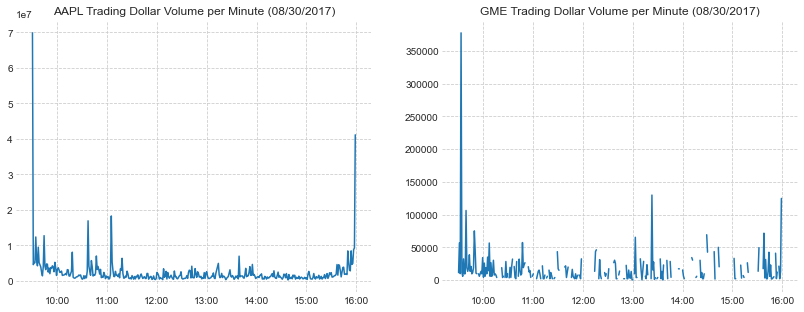

In [13]:
plotter_default(dollar_vol_df, 'Trading Dollar Volume', 0)

## b. Number of trades and orders per minute

In [14]:
num_trades_df = equity_summary.num_trades()
num_trades_df.head()

SYMBOL_NAME,NASDAQ::AAPL,NASDAQ::GME
TIMESTAMP,,
2017-08-30 09:30:00-04:00,443.0,5.0
2017-08-30 09:31:00-04:00,254.0,28.0
2017-08-30 09:32:00-04:00,289.0,6.0
2017-08-30 09:33:00-04:00,316.0,5.0
2017-08-30 09:34:00-04:00,604.0,3.0


In [15]:
num_trades_df.describe()

SYMBOL_NAME,NASDAQ::AAPL,NASDAQ::GME
count,390.000000,259.000000
mean,110.797436,7.096525
std,116.658853,6.959068
min,15.000000,1.000000
25%,52.000000,2.000000
50%,81.000000,5.000000
75%,121.000000,10.000000
max,1279.000000,49.000000


In [16]:
num_orders_df = equity_summary.num_orders()
num_orders_df.head()

SYMBOL_NAME,NASDAQ::AAPL,NASDAQ::GME
TIMESTAMP,,
2017-08-30 09:30:00-04:00,1163,96
2017-08-30 09:31:00-04:00,1351,374
2017-08-30 09:32:00-04:00,1718,150
2017-08-30 09:33:00-04:00,2107,116
2017-08-30 09:34:00-04:00,3777,29


In [17]:
num_orders_df.describe()

SYMBOL_NAME,NASDAQ::AAPL,NASDAQ::GME
count,390.000000,390.000000
mean,2370.600000,128.238462
std,1145.853869,114.274450
min,494.000000,1.000000
25%,1572.500000,34.250000
50%,2124.500000,90.000000
75%,2878.500000,192.000000
max,9733.000000,577.000000


In [18]:
def plot_num_trades_orders(num_trades_df, num_orders_df):
    """Plot number of trades and orders"""
    
    symbols = num_trades_df.columns
    date = num_trades_df.index[0].strftime('%m/%d/%Y')
    frequency = str(num_trades_df.index.freq).replace('<', '').replace('>','')
    
    fig, axs = plt.subplots(1, len(symbols), figsize=(7*len(symbols), 5))
    for i in range(len(symbols)):
        axs[i].plot(num_trades_df[symbols[i]], color='tab:blue', alpha=0.75, label='Number of Trades (Left)')
        axs[i].grid(False)
        axs[i].legend(loc='upper left')
        axtwin = axs[i].twinx()
        axtwin.plot(num_orders_df[symbols[i]], color='tab:orange', alpha=0.75, label='Number of Orders (Right)')
        axtwin.grid(False)
        axtwin.legend(loc='upper right')
        axs[i].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
        axs[i].set_title('{0} Number of Trades and Orders per {1} ({2})'.format(symbols[i].replace('NASDAQ::', ''), frequency, date))


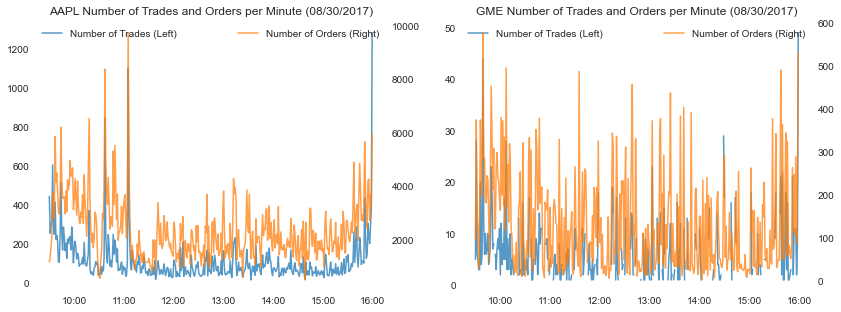

In [19]:
plot_num_trades_orders(num_trades_df, num_orders_df)

## c. Open, close, high, and low prices

In [20]:
equity_summary.daily_summary()

,NASDAQ::AAPL,NASDAQ::GME
Num Trades,43211.00,1838.000
Num Orders,924534.00,50013.000
Open,163.72,18.740
Close,163.33,18.790
High,163.89,18.965
Low,162.62,18.690


## d. VWAP per minute

In [21]:
vwap_df = equity_summary.vwap()
vwap_df.head()

SYMBOL_NAME,NASDAQ::AAPL,NASDAQ::GME
TIMESTAMP,,
2017-08-30 09:30:00-04:00,163.787966,18.746667
2017-08-30 09:31:00-04:00,163.717180,18.882000
2017-08-30 09:32:00-04:00,163.731363,18.910196
2017-08-30 09:33:00-04:00,163.813121,18.799950
2017-08-30 09:34:00-04:00,163.544754,18.746667


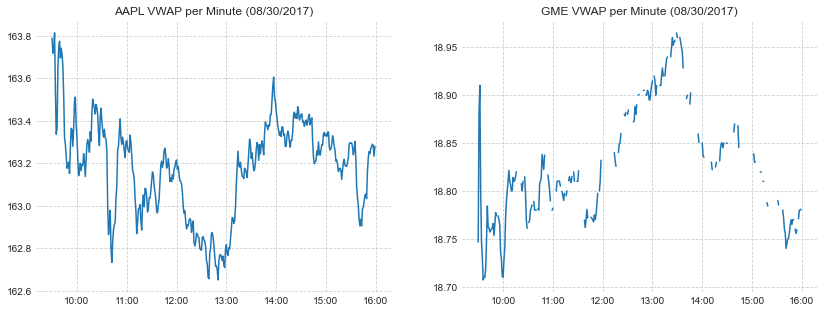

In [22]:
plotter_default(vwap_df, 'VWAP')

## e. BBO spread and depth per minute

In [23]:
bbo_spread_df = equity_summary.bbo_spread()['bbo_spread']
bbo_spread_df.head()

SYMBOL_NAME,NASDAQ::AAPL,NASDAQ::GME
TIMESTAMP,,
2017-08-30 09:30:00-04:00,0.082269,0.049559
2017-08-30 09:31:00-04:00,0.055117,0.056764
2017-08-30 09:32:00-04:00,0.044156,0.057946
2017-08-30 09:33:00-04:00,0.040530,0.038337
2017-08-30 09:34:00-04:00,0.029804,0.039783


In [24]:
def plot_bbo_spread(bbo_spread_df, vwap_df):
    """Plot bbo_spread and bbo_spread/vwap from given df"""
    
    symbols = bbo_spread_df.columns
    date = bbo_spread_df.index[0].strftime('%m/%d/%Y')
    frequency = str(bbo_spread_df.index.freq).replace('<', '').replace('>','')
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    for i in range(len(symbols)):
        axs[0].plot(bbo_spread_df[symbols[i]], label=symbols[i].replace('NASDAQ::', ''))
        axs[1].plot(bbo_spread_df[symbols[i]] / vwap_df[symbols[i]], label=symbols[i].replace('NASDAQ::', ''))
    
    axs[0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axs[1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axs[0].legend()
    axs[1].legend()
    
    axs[0].set_title('Time-Weighted BBO Spread per {0} ({1})'.format(frequency, date))
    axs[1].set_title('Time-Weighted BBO Spread / VWAP per {0} ({1})'.format(frequency, date))
    

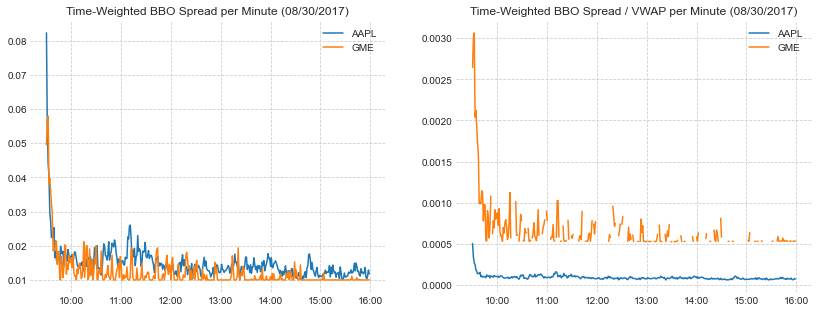

In [25]:
plot_bbo_spread(bbo_spread_df, vwap_df)

In [26]:
bo_depth_1 = equity_summary.bo_depth([1])
bo_depth_1.head()

ASK_SIZE1                BID_SIZE1             
SYMBOL_NAME               NASDAQ::AAPL NASDAQ::GME NASDAQ::AAPL  NASDAQ::GME
TIMESTAMP                                                                   
2017-08-30 09:30:00-04:00   480.836038  102.461778   494.141154   421.588329
2017-08-30 09:31:00-04:00   262.234521  167.675396   335.369331   164.840677
2017-08-30 09:32:00-04:00   277.272407  163.967639   615.817001  1964.535345
2017-08-30 09:33:00-04:00   307.322688  476.121319   224.402386  1169.762269
2017-08-30 09:34:00-04:00   313.926129  481.895167   362.263395   200.433611

In [27]:
def plot_level1_depth(bo_depth_df):
    """Plot bid and ask depth from first level of lob"""
    
    # define bid and ask depths
    ask_depth_1 = bo_depth_df['ASK_SIZE1']
    bid_depth_1 = bo_depth_df['BID_SIZE1']
    
    symbols = ask_depth_1.columns
    date = bo_depth_df.index[0].strftime('%m/%d/%Y')
    frequency = str(bo_depth_df.index.freq).replace('<', '').replace('>','')
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    for i in range(len(symbols)):
        axs[0].plot(ask_depth_1[symbols[i]], label=symbols[i].replace('NASDAQ::', ''))
        axs[1].plot(bid_depth_1[symbols[i]], label=symbols[i].replace('NASDAQ::', ''))
    
    axs[0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axs[1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axs[0].legend()
    axs[1].legend()
    
    axs[0].set_title('Time-Weighted Level 1 Ask Depth per {0} ({1})'.format(frequency, date))
    axs[1].set_title('Time-Weighted Level 1 Bid Depth / VWAP per {0} ({1})'.format(frequency, date))
    

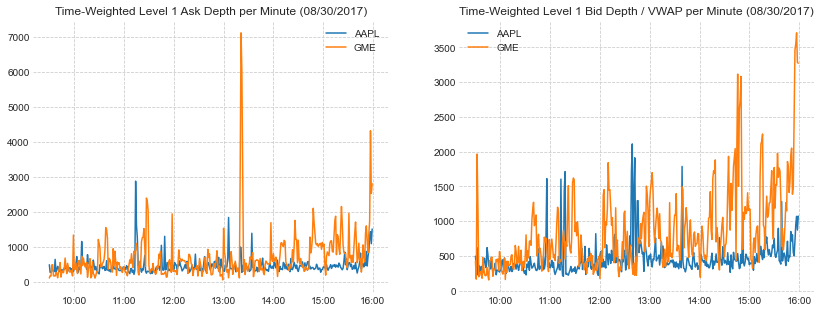

In [28]:
plot_level1_depth(bo_depth_1)

## f. Depth at twice the day's average spread

In [29]:
bo_depth_2xs = equity_summary.depth_2xs_avg_spread()
bo_depth_2xs.head()

ask_size_2xs             bid_size_2xs             
SYMBOL_NAME               NASDAQ::AAPL NASDAQ::GME NASDAQ::AAPL  NASDAQ::GME
TIMESTAMP                                                                   
2017-08-30 09:30:00-04:00    52.506131   33.893667   104.625627   175.913722
2017-08-30 09:31:00-04:00   182.788072   33.736588   139.996708    26.441331
2017-08-30 09:32:00-04:00   321.571704   71.113444   683.185506  1906.626639
2017-08-30 09:33:00-04:00   430.764157  505.435819   316.773338  1191.341046
2017-08-30 09:34:00-04:00   511.565276  481.855056   775.288927   200.380056

In [30]:
def plot_2xs_depth(bo_depth_df, bo_depth_2xs_df):
    """Plot bid and ask depth within twice the average daily spread"""
    
    # define level 1bid and ask depths
    ask_depth_1 = bo_depth_df['ASK_SIZE1']
    bid_depth_1 = bo_depth_df['BID_SIZE1']
    
    # define depths within 2x the average spread
    ask_depth_2xs = bo_depth_2xs_df['ask_size_2xs']
    bid_depth_2xs = bo_depth_2xs_df['bid_size_2xs']
    
    symbols = ask_depth_1.columns
    date = bo_depth_df.index[0].strftime('%m/%d/%Y')
    frequency = str(bo_depth_df.index.freq).replace('<', '').replace('>','')
    
    fig, axs = plt.subplots(len(symbols), 2, figsize=(16, 5*len(symbols)))
    for i in range(len(symbols)):
        axs[i][0].plot(ask_depth_1[symbols[i]], label='Depth')
        axs[i][0].plot(ask_depth_2xs[symbols[i]], label='Depth at 2x Mean Daily Spread')
        axs[i][0].set_title('{0} Ask Depth per {1} ({2})'.format(symbols[i].replace('NASDAQ::', ''), frequency, date))
        axs[i][0].legend()
        axs[i][0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
        
        axs[i][1].plot(bid_depth_1[symbols[i]], label='Depth')
        axs[i][1].plot(bid_depth_2xs[symbols[i]], label='Depth at 2x Mean Daily Spread')
        axs[i][1].set_title('{0} Bid Depth per {1} ({2})'.format(symbols[i].replace('NASDAQ::', ''), frequency, date))
        axs[i][1].legend()
        axs[i][1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
        
    

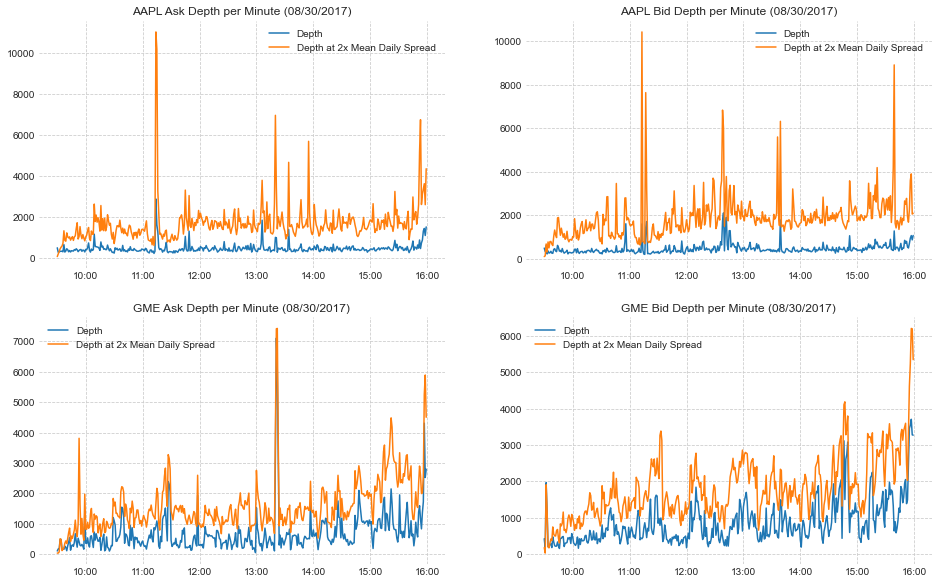

In [31]:
plot_2xs_depth(bo_depth_1, bo_depth_2xs)

## g. Five second price impact (regress 5-second midpoint return on current trade sign, -1 or +1) per five minutes

In [32]:
price_impact_df = equity_summary.price_impact(n_sec=5, min_freq=5)
price_impact_df.head()

/opt/miniconda3/envs/default_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


price_impact                std_error            
SYMBOL_NAME               NASDAQ::AAPL NASDAQ::GME NASDAQ::AAPL NASDAQ::GME
TIMESTAMP                                                                  
2017-08-30 09:35:00-04:00    -0.000008    0.000509     0.000009    0.000211
2017-08-30 09:40:00-04:00     0.000024    0.000090     0.000006    0.000109
2017-08-30 09:45:00-04:00     0.000027    0.000362     0.000007    0.000064
2017-08-30 09:50:00-04:00     0.000031    0.000238     0.000005    0.000076
2017-08-30 09:55:00-04:00     0.000014    0.000188     0.000006    0.000081

In [33]:
def plot_price_impact(price_impact_df):
    """Plot price impact"""
    
    symbols = price_impact_df['price_impact'].columns
    date = price_impact_df.index[0].strftime('%m/%d/%Y')
    frequency = str(price_impact_df.index.freq).replace('<', '').replace('>','')
    
    fig, axs = plt.subplots(len(symbols), 1, figsize=(8, 5*len(symbols)))
    for i in range(len(symbols)):
        symbol_price_impact = price_impact_df['price_impact'][symbols[i]].dropna()
        symbol_std_error = price_impact_df['std_error'][symbols[i]]
        axs[i].plot(symbol_price_impact, label='Price Impact Coefficient')
        axs[i].fill_between(price_impact_df['price_impact'].index, symbol_price_impact - 1.96 * symbol_std_error, symbol_price_impact + 1.96 * symbol_std_error, alpha=0.5, label='95% Confidence Interval')
        axs[i].set_title('{} 5 Second Price Impact (5 Minute Window) (08/30/17)'.format(symbols[i].replace('NASDAQ::', '')))
        axs[i].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))


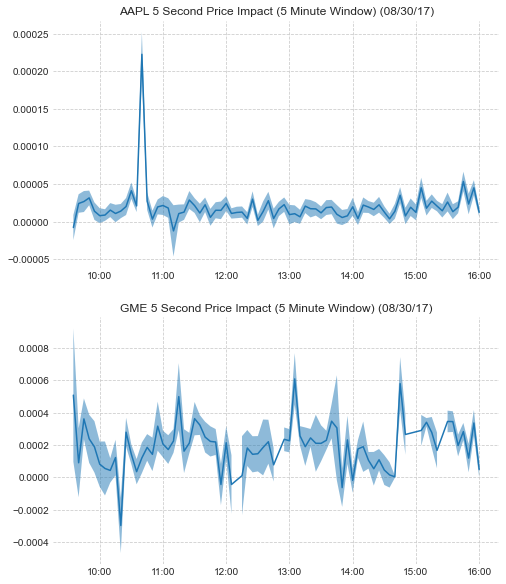

In [34]:
plot_price_impact(price_impact_df)

# Currencies

### Loading in data and doing initial preprocessing

In [35]:
order_curr_df = pd.read_csv('ORDER CURRENCY.csv')
order_curr_df.head()

,Index,Time,EBS_BOOK::EUR/JPY.DELETED_TIME,EBS_BOOK::EUR/JPY.NUM_PARTCP,EBS_BOOK::EUR/JPY.BUY_SELL_FLAG,EBS_BOOK::EUR/JPY.TICK_STATUS,EBS_BOOK::EUR/JPY.RECORD_TYPE,EBS_BOOK::EUR/JPY.PRICE,EBS_BOOK::EUR/JPY.SIZE,EBS_BOOK::EUR/JPY.OMDSEQ,...,EBS_BOOK::EUR/USD.SIZE,EBS_BOOK::EUR/USD.OMDSEQ,EBS_BOOK::USD/JPY.DELETED_TIME,EBS_BOOK::USD/JPY.NUM_PARTCP,EBS_BOOK::USD/JPY.BUY_SELL_FLAG,EBS_BOOK::USD/JPY.TICK_STATUS,EBS_BOOK::USD/JPY.RECORD_TYPE,EBS_BOOK::USD/JPY.PRICE,EBS_BOOK::USD/JPY.SIZE,EBS_BOOK::USD/JPY.OMDSEQ
0,1,2012/01/25 09:30:00.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4000000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2012/01/25 09:30:00.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1000000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2012/01/25 09:30:00.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2012/01/25 09:30:00.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6000000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2012/01/25 09:30:00.500,NaN,1.0,0.0,0.0,R,101.24,1000000.0,0.0,...,NaN,NaN,NaN,2.0,0.0,0.0,R,78.053,2000000.0,1.0


In [36]:
trade_curr_df = pd.read_csv('TRADE CURRENCY.csv')
trade_curr_df.head()

,Index,Time,EBS_BOOK::EUR/USD.BUY_SELL_FLAG,EBS_BOOK::EUR/USD.NUM_PARTCP,EBS_BOOK::EUR/USD.PRICE,EBS_BOOK::EUR/USD.SIZE,EBS_BOOK::EUR/USD.TOTAL_SIZE,EBS_BOOK::EUR/USD.OMDSEQ,EBS_BOOK::USD/JPY.BUY_SELL_FLAG,EBS_BOOK::USD/JPY.NUM_PARTCP,EBS_BOOK::USD/JPY.PRICE,EBS_BOOK::USD/JPY.SIZE,EBS_BOOK::USD/JPY.TOTAL_SIZE,EBS_BOOK::USD/JPY.OMDSEQ,EBS_BOOK::EUR/JPY.BUY_SELL_FLAG,EBS_BOOK::EUR/JPY.NUM_PARTCP,EBS_BOOK::EUR/JPY.PRICE,EBS_BOOK::EUR/JPY.SIZE,EBS_BOOK::EUR/JPY.TOTAL_SIZE,EBS_BOOK::EUR/JPY.OMDSEQ
0,1,2012/01/25 09:30:06.500,0.0,3.0,1.29736,4000000.0,4000000.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2012/01/25 09:30:06.500,1.0,1.0,1.29736,1000000.0,2000000.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2012/01/25 09:30:06.800,1.0,3.0,1.29740,4000000.0,4000000.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2012/01/25 09:30:07.000,0.0,1.0,1.29742,1000000.0,1000000.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2012/01/25 09:30:07.000,1.0,1.0,1.29749,1000000.0,1000000.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
def load_fx_data(csv_loc, curr_pairs):
    """Loads in and does some initial preprocessing for the currencies data"""
    
    # loading and initial preprocessing
    df = pd.read_csv(csv_loc)
    df.columns = df.columns.str.replace('EBS_BOOK::', '')
    df.drop(['Index'], axis=1, inplace=True)
    df['Time'] = pd.to_datetime(df['Time'])
    df.rename(columns={'Time': 'TIMESTAMP'}, inplace=True)
    df.dropna(how='all', inplace=True)
    
    # reorganize df to have just one column denoting the currency pair for each row
    dfs = []
    for curr_pair in curr_pairs:
        
        # get subset of data for each currency pair
        curr_pair_cols = ['TIMESTAMP'] + list(df.columns[df.columns.str.contains(curr_pair)])
        df_curr = df.loc[:, curr_pair_cols].copy()
        df_curr.set_index('TIMESTAMP', inplace=True)
        
        # drop rows with all nans
        df_curr.dropna(how='all', inplace=True)
        
        # get rid of currency pair names from columns and reset index
        df_curr.columns = df_curr.columns.str.replace(curr_pair + '.', '', regex=True)
        df_curr['SYMBOL_NAME'] = curr_pair
        df_curr.reset_index(inplace=True)
        
        dfs.append(df_curr)
    
    # concatenate dfs
    dfs = pd.concat(dfs, axis=0, ignore_index=True)
    
    # drop columns not used 
    dfs.drop(['OMDSEQ', 'NUM_PARTCP'], axis=1, inplace=True)
    
    return dfs

In [38]:
fx_symbols = ['EUR/USD', 'USD/JPY', 'EUR/JPY']
fx_trade_df = load_fx_data('TRADE CURRENCY.csv', fx_symbols)
fx_trade_df = fx_trade_df[fx_trade_df['SIZE'] != 0]
fx_trade_df

,TIMESTAMP,BUY_SELL_FLAG,PRICE,SIZE,TOTAL_SIZE,SYMBOL_NAME
0,2012-01-25 09:30:06.500,0.0,1.29736,4000000.0,4000000.0,EUR/USD
1,2012-01-25 09:30:06.500,1.0,1.29736,1000000.0,2000000.0,EUR/USD
2,2012-01-25 09:30:06.800,1.0,1.29740,4000000.0,4000000.0,EUR/USD
3,2012-01-25 09:30:07.000,0.0,1.29742,1000000.0,1000000.0,EUR/USD
4,2012-01-25 09:30:07.000,1.0,1.29749,1000000.0,1000000.0,EUR/USD
...,...,...,...,...,...,...
22113,2012-01-25 15:56:10.100,0.0,101.90000,1000000.0,1000000.0,EUR/JPY
22114,2012-01-25 15:56:10.200,0.0,101.89600,1000000.0,1000000.0,EUR/JPY
22115,2012-01-25 15:56:57.400,0.0,101.89600,1000000.0,1000000.0,EUR/JPY
22116,2012-01-25 15:58:00.200,1.0,101.91900,1000000.0,6000000.0,EUR/JPY


In [39]:
# load in data and drop unnecessary cols and fix buy_sell_flag
order_curr_df = load_fx_data('ORDER CURRENCY.csv', fx_symbols)
order_curr_df.drop(['DELETED_TIME', 'TICK_STATUS', 'RECORD_TYPE'], axis=1, inplace=True)
order_curr_df['BUY_SELL_FLAG'] = order_curr_df['BUY_SELL_FLAG'].map({1: -1, 0: 1})

order_curr_df.head()

,TIMESTAMP,BUY_SELL_FLAG,PRICE,SIZE,SYMBOL_NAME
0,2012-01-25 09:30:00.100,1,1.29707,4000000.0,EUR/USD
1,2012-01-25 09:30:00.100,1,1.29697,1000000.0,EUR/USD
2,2012-01-25 09:30:00.100,1,1.29691,0.0,EUR/USD
3,2012-01-25 09:30:00.400,1,1.29700,6000000.0,EUR/USD
4,2012-01-25 09:30:00.700,1,1.29720,1000000.0,EUR/USD


#### Create LOB from orders data (to have same format as equities LOB)

In [40]:
def create_lob(order_curr_df, lob_size=3):
    """Returns a combined df of the LOB's for the symbols in order_curr_df"""
    
    # used later for naming columns
    lob_sides = {1: 'BID', -1: 'ASK'}
    
    # construct the limit order book for each security then concat at the end
    all_lobs = []
    for fx_symbol in fx_symbols:
        # filter down df to just one fx_symbol
        curr_pair_df = order_curr_df.query('SYMBOL_NAME == "{}"'.format(fx_symbol))
        
        # construct the ask side lob and bid side lob separately then concat at the end
        lobs = []
        for flag in [-1, 1]:
            # filter down to just have asks or bids
            curr_pair_flag = curr_pair_df.query('BUY_SELL_FLAG == {}'.format(flag))
            
            # get the prices and sizes of the top three quotes at each point in time
            lob_prices, lob_sizes = [], []
            actives = {}
            for row in curr_pair_flag.itertuples():
                
                # update lob with the current size for a given price
                actives[row.PRICE] = row.SIZE
                
                # remove price from actives if size changed to 0
                if row.SIZE == 0:
                    actives.pop(row.PRICE)

                # sort keys to get largest ones for asks and smallest for bids
                keys_list = sorted(actives.keys(), reverse=flag)
                largest_bids = keys_list[:lob_size]

                # save out prices and corresponding sizes for top three quotes at each time
                lob_prices.append([row.TIMESTAMP] + largest_bids)
                lob_sizes.append([actives[bid] for bid in largest_bids])

            # convert prices to df
            price_cols = ['TIMESTAMP'] + ['{0}_PRICE{1}'.format(lob_sides[flag], i) for i in range(1, lob_size + 1)]
            lob_prices = pd.DataFrame(lob_prices, columns=price_cols)

            # convert sizes to df
            size_cols = ['{0}_SIZE{1}'.format(lob_sides[flag], i) for i in range(1, lob_size + 1)]
            lob_sizes = pd.DataFrame(lob_sizes, columns=size_cols)

            # concatenate to get lob with prices and sizes
            lob = pd.concat([lob_prices, lob_sizes], axis=1)
            lob.drop_duplicates(keep='last', subset='TIMESTAMP', inplace=True)
            lobs.append(lob)
        
        # combine bid/ask lobs together, sort on time, then ffill, and keep last row per time
        lob_bid_ask = pd.concat(lobs, axis=0)
        lob_bid_ask.sort_values('TIMESTAMP', inplace=True)
        lob_bid_ask.ffill(inplace=True)
        lob_bid_ask.drop_duplicates(keep='last', inplace=True)
        lob_bid_ask['SYMBOL_NAME'] = fx_symbol
        all_lobs.append(lob_bid_ask)
    
    # concat all lobs together 
    all_lobs = pd.concat(all_lobs, axis=0)
    all_lobs.drop_duplicates(['TIMESTAMP', 'SYMBOL_NAME'], keep='last', inplace=True)
    return all_lobs


In [41]:
fx_order_df = create_lob(order_curr_df, 3)
fx_order_df.head()

,TIMESTAMP,ASK_PRICE1,ASK_PRICE2,ASK_PRICE3,ASK_SIZE1,ASK_SIZE2,ASK_SIZE3,BID_PRICE1,BID_PRICE2,BID_PRICE3,BID_SIZE1,BID_SIZE2,BID_SIZE3,SYMBOL_NAME
2,2012-01-25 09:30:00.100,NaN,NaN,NaN,NaN,NaN,NaN,1.29707,1.29697,NaN,4000000.0,1000000.0,NaN,EUR/USD
3,2012-01-25 09:30:00.400,NaN,NaN,NaN,NaN,NaN,NaN,1.29707,1.29700,1.29697,4000000.0,6000000.0,1000000.0,EUR/USD
13,2012-01-25 09:30:00.700,1.29742,1.29740,1.29739,2000000.0,4000000.0,3000000.0,1.29720,1.29715,1.29714,1000000.0,2000000.0,1000000.0,EUR/USD
17,2012-01-25 09:30:00.800,1.29744,1.29742,1.29740,2000000.0,2000000.0,3000000.0,1.29720,1.29715,1.29714,1000000.0,2000000.0,2000000.0,EUR/USD
21,2012-01-25 09:30:00.900,1.29744,1.29742,1.29740,2000000.0,2000000.0,2000000.0,1.29720,1.29715,1.29714,1000000.0,2000000.0,2000000.0,EUR/USD


## Display FX summary results

## a. Dollar trading volume per minute

In [42]:
fx_summary = DataSummary(fx_trade_df, fx_order_df)

In [43]:
fx_dollar_vol_df = fx_summary.dollar_vol()
fx_dollar_vol_df.head()

SYMBOL_NAME,EUR/JPY,EUR/USD,USD/JPY
TIMESTAMP,,,
2012-01-25 09:30:00,1.012430e+08,49295180.0,1.326900e+09
2012-01-25 09:31:00,3.036820e+08,145271230.0,2.185498e+09
2012-01-25 09:32:00,2.024003e+09,137446230.0,1.014899e+09
2012-01-25 09:33:00,2.429051e+09,66117480.0,1.405314e+09
2012-01-25 09:34:00,2.834249e+09,80361520.0,2.186754e+09


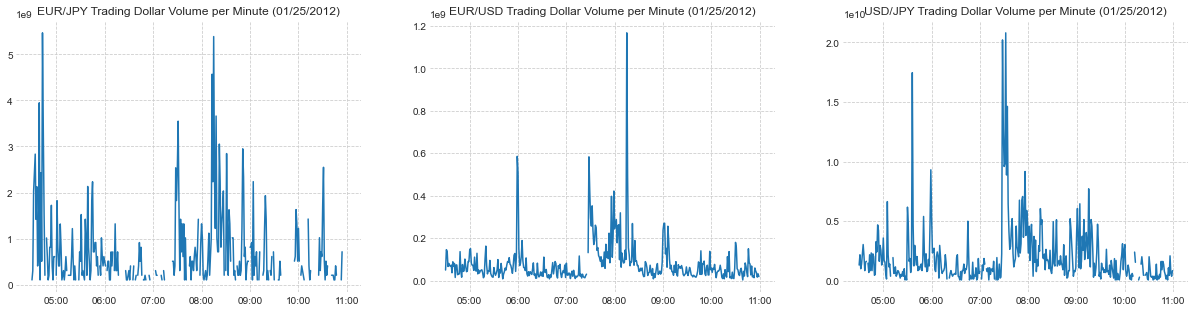

In [44]:
plotter_default(fx_dollar_vol_df, 'Trading Dollar Volume', 0)

## b. Number of trades and orders per minute

In [45]:
fx_num_trades_df = fx_summary.num_trades()
fx_num_trades_df.head()

SYMBOL_NAME,EUR/JPY,EUR/USD,USD/JPY
TIMESTAMP,,,
2012-01-25 09:30:00,1.0,21.0,12.0
2012-01-25 09:31:00,3.0,58.0,15.0
2012-01-25 09:32:00,4.0,41.0,11.0
2012-01-25 09:33:00,11.0,29.0,14.0
2012-01-25 09:34:00,19.0,44.0,20.0


In [46]:
fx_num_trades_df.describe()

SYMBOL_NAME,EUR/JPY,EUR/USD,USD/JPY
count,307.000000,389.000000,377.000000
mean,5.022801,37.365039,16.023873
std,5.071012,36.634661,16.890195
min,1.000000,2.000000,1.000000
25%,2.000000,16.000000,6.000000
50%,3.000000,27.000000,11.000000
75%,6.000000,42.000000,20.000000
max,37.000000,340.000000,155.000000


In [47]:
fx_num_orders_df = fx_summary.num_orders()
fx_num_orders_df.head()

SYMBOL_NAME,EUR/JPY,EUR/USD,USD/JPY
TIMESTAMP,,,
2012-01-25 09:30:00,222,308,84
2012-01-25 09:31:00,209,286,150
2012-01-25 09:32:00,245,358,140
2012-01-25 09:33:00,191,266,144
2012-01-25 09:34:00,177,308,159


In [48]:
fx_num_orders_df.describe()

SYMBOL_NAME,EUR/JPY,EUR/USD,USD/JPY
count,390.000000,390.000000,390.000000
mean,138.246154,220.364103,129.748718
std,67.946304,93.034785,74.254675
min,18.000000,51.000000,12.000000
25%,92.000000,155.250000,80.000000
50%,129.000000,210.000000,114.500000
75%,172.000000,273.750000,168.500000
max,462.000000,556.000000,466.000000


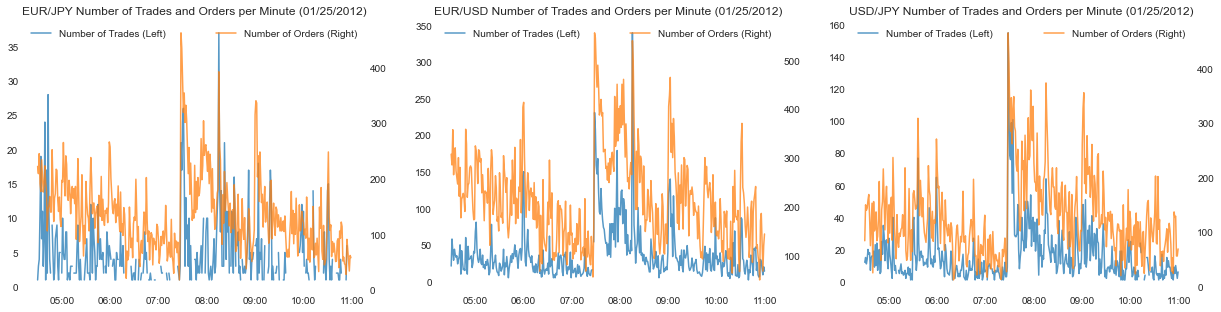

In [49]:
plot_num_trades_orders(fx_num_trades_df, fx_num_orders_df)

## c. Open, close, high, and low prices

In [50]:
fx_summary.daily_summary()

,EUR/USD,USD/JPY,EUR/JPY
Num Trades,14535.00000,6041.000,1542.000
Num Orders,85944.00000,50602.000,53917.000
Open,1.29736,78.053,101.243
Close,1.31130,77.730,101.920
High,1.31209,78.288,101.949
Low,1.29470,77.560,101.200


## d. VWAP per minute

In [51]:
fx_vwap = fx_summary.vwap()
fx_vwap.head()

SYMBOL_NAME,EUR/JPY,EUR/USD,USD/JPY
TIMESTAMP,,,
2012-01-25 09:30:00,101.243000,1.297242,78.052941
2012-01-25 09:31:00,101.227333,1.297065,78.053500
2012-01-25 09:32:00,101.200150,1.296663,78.069154
2012-01-25 09:33:00,101.210458,1.296421,78.073000
2012-01-25 09:34:00,101.223179,1.296154,78.098357


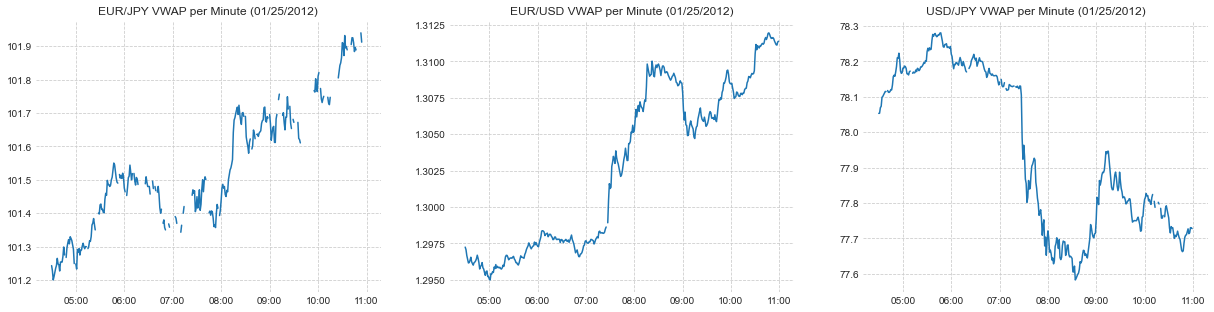

In [52]:
plotter_default(fx_vwap, 'VWAP')

## e. BBO spread and depth per minute

In [53]:
fx_bbo_spread = fx_summary.bbo_spread()['bbo_spread']
fx_bbo_spread.head()

SYMBOL_NAME,EUR/JPY,EUR/USD,USD/JPY
TIMESTAMP,,,
2012-01-25 09:30:00,0.041226,0.000262,0.020341
2012-01-25 09:31:00,0.038813,0.000232,0.021535
2012-01-25 09:32:00,0.040650,0.000237,0.022077
2012-01-25 09:33:00,0.040500,0.000243,0.024790
2012-01-25 09:34:00,0.039803,0.000243,0.019682


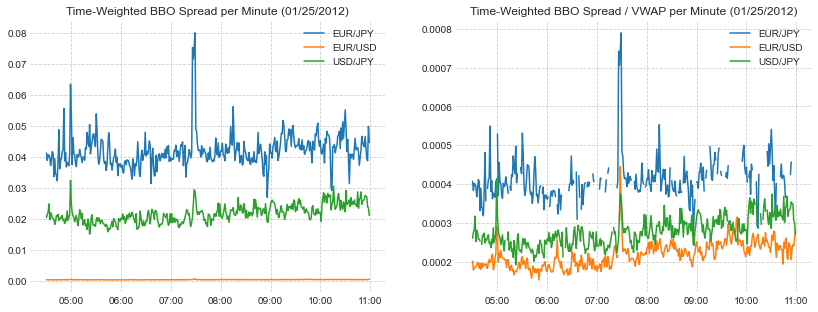

In [54]:
plot_bbo_spread(fx_bbo_spread, fx_vwap)

In [55]:
fx_bo_depth_1 = fx_summary.bo_depth([1])
fx_bo_depth_1.head()

ASK_SIZE1                                 BID_SIZE1  \
SYMBOL_NAME               EUR/JPY       EUR/USD       USD/JPY       EUR/JPY   
TIMESTAMP                                                                     
2012-01-25 09:30:00  1.410774e+06  2.428331e+06  2.090756e+06  1.643697e+06   
2012-01-25 09:31:00  1.820000e+06  2.626667e+06  3.648333e+06  1.291667e+06   
2012-01-25 09:32:00  2.310000e+06  2.371667e+06  2.165000e+06  1.805000e+06   
2012-01-25 09:33:00  3.403333e+06  4.176667e+06  2.535000e+06  1.685000e+06   
2012-01-25 09:34:00  2.396667e+06  1.971667e+06  2.395000e+06  1.593333e+06   

                                                 
SYMBOL_NAME               EUR/USD       USD/JPY  
TIMESTAMP                                        
2012-01-25 09:30:00  1.873122e+06  1.115966e+06  
2012-01-25 09:31:00  3.438333e+06  3.005000e+06  
2012-01-25 09:32:00  4.243333e+06  2.096667e+06  
2012-01-25 09:33:00  1.531667e+06  2.306667e+06  
2012-01-25 09:34:00  3.016667e+06  1.818333e+06

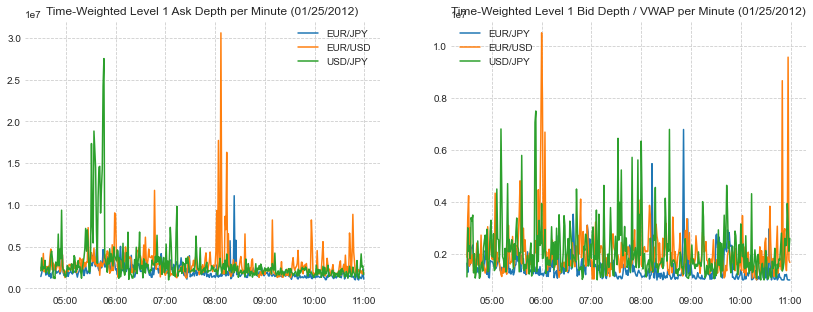

In [56]:
plot_level1_depth(fx_bo_depth_1)

## f. Depth at twice the day's average spread

In [57]:
fx_bo_depth_2xs = fx_summary.depth_2xs_avg_spread()
fx_bo_depth_2xs.head()

ask_size_2xs                              bid_size_2xs  \
SYMBOL_NAME               EUR/JPY       EUR/USD       USD/JPY       EUR/JPY   
TIMESTAMP                                                                     
2012-01-25 09:30:00  6.347899e+06  7.607679e+06  9.179832e+06  4.457143e+06   
2012-01-25 09:31:00  5.445000e+06  7.488333e+06  8.903333e+06  4.968333e+06   
2012-01-25 09:32:00  5.923333e+06  7.586667e+06  6.221667e+06  5.250000e+06   
2012-01-25 09:33:00  6.450000e+06  1.168833e+07  8.855000e+06  4.741667e+06   
2012-01-25 09:34:00  7.341667e+06  6.291667e+06  7.665000e+06  4.926667e+06   

                                                 
SYMBOL_NAME               EUR/USD       USD/JPY  
TIMESTAMP                                        
2012-01-25 09:30:00  5.065109e+06  5.473950e+06  
2012-01-25 09:31:00  7.628333e+06  8.103333e+06  
2012-01-25 09:32:00  9.528333e+06  5.263333e+06  
2012-01-25 09:33:00  5.950000e+06  7.328333e+06  
2012-01-25 09:34:00  9.980000e+06  6.386667e+06

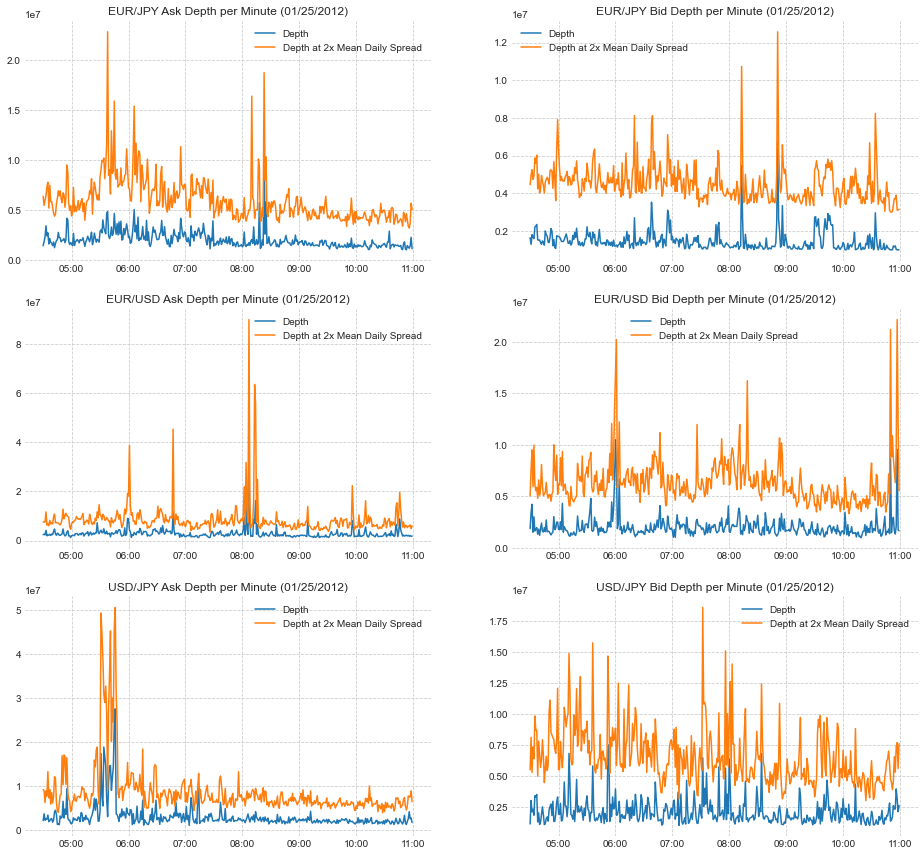

In [58]:
plot_2xs_depth(fx_bo_depth_1, fx_bo_depth_2xs)

## g. Five second price impact (regress 5-second midpoint return on current trade sign, -1 or +1) per five minutes

In [59]:
fx_price_impact_df = fx_summary.price_impact(n_sec=5, min_freq=5)
fx_price_impact_df.head()

/opt/miniconda3/envs/default_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


price_impact                         std_error            \
SYMBOL_NAME              EUR/JPY   EUR/USD       USD/JPY   EUR/JPY   EUR/USD   
TIMESTAMP                                                                      
2012-01-25 09:35:00          NaN -0.000002  3.558270e-07       NaN  0.000005   
2012-01-25 09:36:00     0.000004       NaN           NaN  0.000008       NaN   
2012-01-25 09:40:00          NaN  0.000004  5.523811e-06       NaN  0.000006   
2012-01-25 09:41:00     0.000014       NaN           NaN  0.000012       NaN   
2012-01-25 09:45:00          NaN  0.000003  1.521346e-05       NaN  0.000004   

                               
SYMBOL_NAME           USD/JPY  
TIMESTAMP                      
2012-01-25 09:35:00  0.000006  
2012-01-25 09:36:00       NaN  
2012-01-25 09:40:00  0.000004  
2012-01-25 09:41:00       NaN  
2012-01-25 09:45:00  0.000007

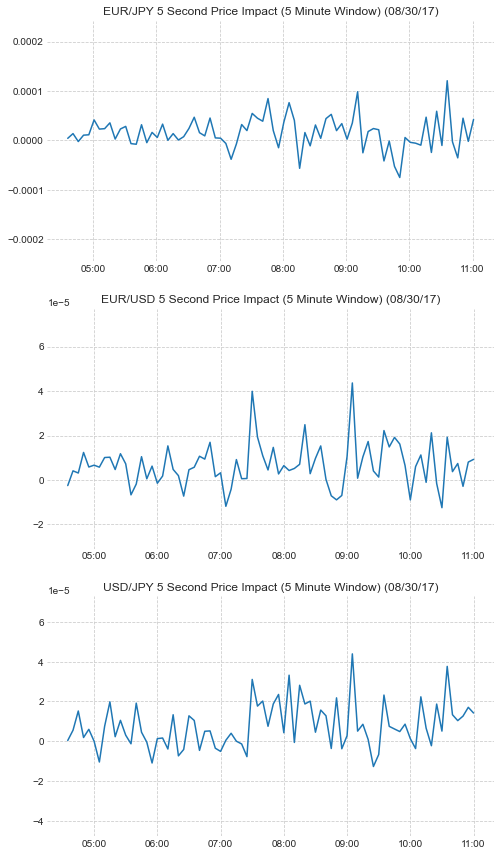

In [60]:
plot_price_impact(fx_price_impact_df)